In [1]:
! apt-get install -y g++ openjdk-8-jdk python3-dev curl git build-essential
! pip install konlpy "tweepy<4.0.0"
! /bin/bash <(curl -s https://raw.githubusercontent.com/konlpy/konlpy/master/scripts/mecab.sh)
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
curl is already the newest version (7.58.0-2ubuntu3.17).
g++ is already the newest version (4:7.4.0-1ubuntu2.3).
g++ set to manually installed.
git is already the newest version (1:2.17.1-1ubuntu0.11).
python3-dev is already the newest version (3.6.7-1~18.04).
python3-dev set to manually installed.
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  fonts-dejavu-core fonts-dejavu-extra libatk-wrapper-java
  libatk-wrapper-java-jni libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin
  libgtk2.0-common libxxf86dga1 openjdk-8-jdk-headless openjdk-8-jre
  openjdk-8-jre-headless x11-utils
Suggested packages:
  gvfs openjdk-8-demo openjdk-8-source visualvm icedtea-8-plugin l

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import sys
import warnings
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch

import datetime
import easydict
import itertools
import json
import pathlib
import pprint
import re
from operator import itemgetter
from pathlib import Path
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from typing import List, Dict


In [4]:
DATA_DIR = '/content/drive/MyDrive/summarization/paper'
TRAIN = DATA_DIR + '/Training/'
VAL = DATA_DIR + '/Validation/'

In [5]:
train_file_list = os.listdir(TRAIN)
val_file_list = os.listdir(VAL)

# .json로 끝나는 리스트 
train_file_lists = [file for file in train_file_list if file.endswith('.json')]
val_file_lists = [file for file in val_file_list if file.endswith('.json')]

In [6]:
print(train_file_lists)
print(val_file_lists)

['논문요약_0220_0.json', '논문요약_0206_0.json', '논문요약_0206_2.json', '논문요약_0206_1.json', '논문요약_0225_7_0.json', '논문요약_0225_5_1.json']
['논문요약_0224_0.json', '논문요약_0225_6_2.json']


In [7]:
dict_list = []
for file in train_file_lists:
    with open(TRAIN+file, 'r', encoding='utf-8') as fd:
        dict_list = json.load(fd)['data']
train_df = pd.DataFrame(dict_list)
train_df

,doc_type,doc_id,title,date,reg_no,ipc,issued_by,author,summary_entire,summary_section
0,논문,A220223614306,지방분권 강화와 레저산업 활성화를 위한 레저세의 개선방안,2017,ART9002280898,사회과학,한국국제회계학회,"정지선 /Chung Ji Sun ,,, 윤성만",[{'orginal_text': '국민소득의 증대와 주5일제 근무 정착으로 다양한 ...,[{'orginal_text': '국민소득의 증대와 주5일제 근무 정착으로 다양한 ...
1,논문,A220223614307,시장 특성이 항공노선 성과에 미치는 영향 : 글로벌 제휴의 조절효과를 중심으로*,2017,ART9002280941,사회과학,한국기업경영학회,"신태진,양지연,이윤철 /Yuncheol Lee",[{'orginal_text': '노선(route)은 항공사 수익 결정의 핵심 요인...,[{'orginal_text': '항공운송산업에 있어 노선 간 제휴는 전 세계적인 ...
2,논문,A220223614308,시각적 이미지 안에서 삼각형 높이의 개념 이미지에 대한 인지적 처리과정과 인지적 부하,2017,ART9002281348,사회과학,한국수학교육학회,"이미진,이광호 /KwanghoLee",[{'orginal_text': '삼각형 높이를 찾는 과정에서 눈 움직임 데이터를 ...,[{'orginal_text': '삼각형은 다각형을 그릴 수 있는 최소 단위로 기하...
3,논문,A220223614309,중소물류기업의 항공특송시장 진출전략 연구- 대신택배 국제운송사업부의 해외진출사례를 ...,2017,ART9002281393,사회과학,한국항공경영학회,"김용정 /KIM YONG JEONG,박재훈",[{'orginal_text': '본 연구는 물류기업인 대신택배 국제운송부서에서 베...,[{'orginal_text': '상대적으로 작은 국토와 부족한 천연자원을 가지고 ...
4,논문,A220223614310,조선 소빙기(小氷期) 해양인식(海洋認識)과 위민사상(爲民思想) 연구 - 강릉ㆍ삼척 ...,2017,ART9002281756,사회과학,한국도서(섬)학회,전제훈 /Jen Je Hun,"[{'orginal_text': '본 연구는 조선왕조실록 속의 강릉, 삼척 등 동해...",[{'orginal_text': '이태진은 『조선왕조실록』의 천재지변(天災地變)에 ...
...,...,...,...,...,...,...,...,...,...,...
31995,논문,A220223646599,식스시그마 경영 성공의 영향 요인에 관한 연구 Factors Influencing ...,2010,ART9001473273,사회과학,한국산업경영학회,김성언 /Sung-Eon Kim,"[{'orginal_text': '기업들은 기업 업무의 질적 개선, 비용 감소, 고...",[{'orginal_text': '불량품에 대한 하자 보수 신청에 대한 판매부서의 ...
31996,논문,A220223646600,9식설과 여래장에 대한 진제의 사유 一考 the Theory of Nine Type...,2010,ART9001473276,인문학,불교학연구회,최은영 /Choi Eun-Young,[{'orginal_text': '중국불교 유식학 연구자들은 9식설의 출발을 진제(...,[{'orginal_text': '중국불교 유식학 연구자들은 9식설의 출발을 진제(...
31997,논문,A220223646601,국내 주식시장에서 거시요인과 주식수익률의 횡단면에 관한 연구 Macro-econom...,2010,ART9001473278,사회과학,한국산업경영학회,"윤상용 /Yun, SangYong",[{'orginal_text': '기업의 미래 현금흐름과 할인율에 직접적으로 영향을...,[{'orginal_text': '일반적으로 주가는 거시경제와 관련된 정보들에 민감...
31998,논문,A220223646602,최고경영자 요인이 기업성장에 미치는 영향 분석: 한화그룹의 기업가정신 역할모형을 중...,2010,ART9001473283,사회과학,한국산업경영학회,"조용래 /Yongrae Cho , 윤건우 , 함정호 , 김원준 /Wonjoon...",[{'orginal_text': '본 연구에서는 최고경영자 요인이 기업성장에 미치는...,[{'orginal_text': '한국경제는 20세기 후반부터 본격적인 지식경제로의...


In [8]:
val_dict_list = []
for file in val_file_lists:
    with open(VAL+file, 'r', encoding='utf-8') as fd:
        val_dict_list = json.load(fd)['data']
val_df = pd.DataFrame(val_dict_list)
val_df

,doc_type,doc_id,title,date,reg_no,ipc,issued_by,author,summary_entire,summary_section
0,논문,A220223646604,아뢰야식(阿賴耶識)의 지평에서 본 타인의 마음 ―법상종(法相宗)의 해석을 중심으로 ...,2010,ART9001473287,인문학,불교학연구회,"백진순 /Baek, Jin-Soon",[{'orginal_text': '이 글은 ‘유식무경(唯識無境)’이라는 교의를 고수...,[{'orginal_text': '유식학자들은 ‘모든 것은 내 마음 안에 나타난 표...
1,논문,A220223646605,쫑카빠의 알라야식(Kun gzhi) 이해와 원측 Ālayavijñāna in Rel...,2010,ART9001473292,인문학,불교학연구회,"차상엽 /Cha, Sangyeob",[{'orginal_text': '본고의 문제의식은 쫑카빠가 알라야식을 어떻게 이해...,"[{'orginal_text': '쫑카빠(1357-1419)는, 무착의 유식전적인 ..."
2,논문,A220223646606,"지원적 인적자원관리에 대한 구성원의 인식이 정서적 몰입, 직무만족, 이직의도에 미치...",2010,ART9001473299,사회과학,한국산업경영학회,"이종찬 /Lee, Jong Chan",[{'orginal_text': '본 연구의 목적은 조직구성원이 이직의도를 갖게 되...,[{'orginal_text': '전 지구적으로 세계화의 물결이 확산되면서 국가별로...
3,논문,A220223646607,불교덕윤리에서 부정적 성향의 제거 ―탐진치의 지멸 The Elimination of...,2010,ART9001473307,인문학,불교학연구회,안옥선 /Ok-Sun An,[{'orginal_text': '이 논문은 불교덕윤리에서 선 실천의 요체인 ‘탐(...,[{'orginal_text': '불교도덕이 덕윤리로서 이해될 수 있음은 선행연구들...
4,논문,A220223646608,조선전기 불교의 이념적 변화 과정 연구 ─의승병(義僧兵)을 중심으로 A Study ...,2010,ART9001473336,인문학,불교학연구회,"박재현 /Park, Jae-hyeon",[{'orginal_text': '조선의 개국은 불교계의 급격한 이념적 변화를 요구...,[{'orginal_text': '승병(僧兵)은 아이러니다. 승(僧)과 병(兵)은 ...
...,...,...,...,...,...,...,...,...,...,...
6254,논문,A220223652858,한국정치사상의 원형 탐구 — 『三國史記』와 『三國遺事』를 중심으로 — A Study...,2014,ART9001922914,인문학,온지학회,"안외순 /Woe Soon, Ahn",[{'orginal_text': '현존하는 最古/最高의 한국 역사서 『三國史記』와 ...,[{'orginal_text': '한 민족의 정체성을 형성하는 결정적인 요소 중의 ...
6255,논문,A220223652859,功夫選의 전개양상과 功夫十節目 A Study on Development of Gon...,2014,ART9001922915,인문학,온지학회,염중섭 /Jungseop Youm,[{'orginal_text': '功夫選은 親政을 선언해서 辛旽과 거리를 두게 된 ...,[{'orginal_text': '고려 말을 대표하는 麗末三師와 嗣承관계에 의한 證...
6256,논문,A220223652860,스토리텔링을 통한 여성 인물의 가치와 의미 — 운초 김부용의 문화콘텐츠를 중심으로 ...,2014,ART9001922916,인문학,온지학회,하경숙 /HA KYOUNG-SOOK,[{'orginal_text': '김부용(金芙蓉)은 조선시대의 여류 문인이다. 호는...,[{'orginal_text': '역사인물의 삶에 관심을 갖고 끊임없이 이야기하는 ...
6257,논문,A220223652861,강원도 홍천군 인물설화의 지역적 특징 연구 — 강촌(江村)지역 전승의 이괄설화를 중...,2014,ART9001922917,인문학,온지학회,최명환 /Myunghwan Choi,"[{'orginal_text': '강(江)의 흐름은 시간과 공간을 초월하며, 강과 ...",[{'orginal_text': '문명이 아니더라도 강에는 강을 생업의 터전으로 하...


In [9]:
columns = ['doc_type', 'title', 'date', 'reg_no', 'issued_by', 'summary_section']

In [10]:
train_df.drop(columns=columns, axis=1, inplace=True)
val_df.drop(columns=columns, axis=1, inplace=True)

In [11]:
a = train_df['summary_entire']
a

0        [{'orginal_text': '국민소득의 증대와 주5일제 근무 정착으로 다양한 ...
1        [{'orginal_text': '노선(route)은 항공사 수익 결정의 핵심 요인...
2        [{'orginal_text': '삼각형 높이를 찾는 과정에서 눈 움직임 데이터를 ...
3        [{'orginal_text': '본 연구는 물류기업인 대신택배 국제운송부서에서 베...
4        [{'orginal_text': '본 연구는 조선왕조실록 속의 강릉, 삼척 등 동해...
                               ...                        
31995    [{'orginal_text': '기업들은 기업 업무의 질적 개선, 비용 감소, 고...
31996    [{'orginal_text': '중국불교 유식학 연구자들은 9식설의 출발을 진제(...
31997    [{'orginal_text': '기업의 미래 현금흐름과 할인율에 직접적으로 영향을...
31998    [{'orginal_text': '본 연구에서는 최고경영자 요인이 기업성장에 미치는...
31999    [{'orginal_text': '본 연구는 후원자와 사회복지기관과의 협력적 관계에...
Name: summary_entire, Length: 32000, dtype: object

In [12]:
a_1 = [line['orginal_text'].replace('\n', '').strip() for line in itertools.chain(*a)]
a_2 = [line['summary_text'].replace('\n', '').strip() for line in itertools.chain(*a)]

In [13]:
original_text = []
for i in range(len(a_1)):
    original_text.append(a_1[i])

summary_text = []
for i in range(len(a_2)):
    summary_text.append(a_2[i])

In [14]:
original_text = pd.DataFrame(original_text)
summary_text = pd.DataFrame(summary_text)

In [15]:
summary_text.columns = ['summary_text']
original_text.columns = ['original_text']

In [16]:
train_df_1 = pd.concat([train_df, original_text], axis=1)
train_df = pd.concat([train_df_1, summary_text], axis=1)

In [17]:
train_df.drop(columns='summary_entire', axis=1, inplace=True)
train_df

,doc_id,ipc,author,original_text,summary_text
0,A220223614306,사회과학,"정지선 /Chung Ji Sun ,,, 윤성만",국민소득의 증대와 주5일제 근무 정착으로 다양한 레저활동에 대한 국민의 관심도가 높...,국민소득의 증대와 주5일제 근무의 정착으로 다양한 레저활동에 대한 국민의 관심도가 ...
1,A220223614307,사회과학,"신태진,양지연,이윤철 /Yuncheol Lee","노선(route)은 항공사 수익 결정의 핵심 요인 중 하나이며, 항공사는 노선의 개...","노선은 항공사 수익 결정의 핵심 요인 중 하나로, 항공사는 노선의 개설 없이 존재 ..."
2,A220223614308,사회과학,"이미진,이광호 /KwanghoLee",삼각형 높이를 찾는 과정에서 눈 움직임 데이터를 통해 학생들의 삼각형 높이에 대한 ...,삼각형 높이를 찾는 과정에서 눈 움직임 데이터를 통하여 학생들의 삼각형 높이에 대한...
3,A220223614309,사회과학,"김용정 /KIM YONG JEONG,박재훈","본 연구는 물류기업인 대신택배 국제운송부서에서 베트남(Vietnam), 호주(Aus...","본 논문은 물류기업인 대신택배 국제운송부서에서 베트남, 호주, 중국의 항공특송시장을..."
4,A220223614310,사회과학,전제훈 /Jen Je Hun,"본 연구는 조선왕조실록 속의 강릉, 삼척 등 동해안을 중심으로 천변지이 현상 속에서...","이 연구는 조선왕조실록 속의 강릉, 삼척 등 동해안을 중심으로 천변지이 현상 속에서..."
...,...,...,...,...,...
31995,A220223646599,사회과학,김성언 /Sung-Eon Kim,"기업들은 기업 업무의 질적 개선, 비용 감소, 고객 충성도 증가 등 기업의 전반적 ...","본 논문에서는 구조방정식 모형 분석은 SmartPLS 2.0을 이용하였으며, 경로 ..."
31996,A220223646600,인문학,최은영 /Choi Eun-Young,중국불교 유식학 연구자들은 9식설의 출발을 진제(眞諦 : Param?rtha 499...,중국불교 유식학 연구자들은 9식설의 출발을 진제(眞諦 : Param?rtha 499...
31997,A220223646601,사회과학,"윤상용 /Yun, SangYong",기업의 미래 현금흐름과 할인율에 직접적으로 영향을 미칠 수 있는 거시경제변수들은 실...,기업의 미래 현금흐름과 할인율에 직접적으로 영향을 줄 수 있는 거시경제변수들은 실제...
31998,A220223646602,사회과학,"조용래 /Yongrae Cho , 윤건우 , 함정호 , 김원준 /Wonjoon...",본 연구에서는 최고경영자 요인이 기업성장에 미치는 영향력을 한화그룹의 3개 사업부문...,이 논문은 최고경영자 요인이 기업성장에 미치는 영향력을 한화그룹의 3개 사업부문의 ...


In [18]:
b = val_df['summary_entire']
b_1 = [line['orginal_text'].replace('\n', '').strip() for line in itertools.chain(*b)]
b_2 = [line['summary_text'].replace('\n', '').strip() for line in itertools.chain(*b)]

In [19]:
original_text_1 = []
for i in range(len(b_1)):
    original_text_1.append(b_1[i])

summary_text_1 = []
for i in range(len(b_2)):
    summary_text_1.append(b_2[i])

In [20]:
original_text_1 = pd.DataFrame(original_text_1)
summary_text_1 = pd.DataFrame(summary_text_1)


summary_text_1.columns = ['summary_text']

original_text_1.columns = ['original_text']

In [21]:
val_df_1 = pd.concat([val_df, original_text_1], axis=1)
val_df = pd.concat([val_df_1, summary_text_1], axis=1)

In [22]:
val_df.drop(columns='summary_entire', axis=1, inplace=True)
val_df

,doc_id,ipc,author,original_text,summary_text
0,A220223646604,인문학,"백진순 /Baek, Jin-Soon",이 글은 ‘유식무경(唯識無境)’이라는 교의를 고수했던 중국 법상종의 입장에서 ‘타인...,본 논문에서는 중국 법상종의 입장에서 ‘타심지(他心智)’의 의미를 고찰하였다. 타심...
1,A220223646605,인문학,"차상엽 /Cha, Sangyeob","본고의 문제의식은 쫑카빠가 알라야식을 어떻게 이해하고 있는지, 그리고 왜 그가 Yi...",이 연구의 문제의식은 쫑카빠가 알라야식을 어떻게 이해하고 있는지와 왜 그가 Yid ...
2,A220223646606,사회과학,"이종찬 /Lee, Jong Chan",본 연구의 목적은 조직구성원이 이직의도를 갖게 되는 과정에서 보상의 공정성이나 의사...,본고는 조직구성원이 이직의도를 갖게 되는 과정에서 보상의 공정성이나 의사결정참여와 ...
3,A220223646607,인문학,안옥선 /Ok-Sun An,이 논문은 불교덕윤리에서 선 실천의 요체인 ‘탐(r?ga/lobha)진(dosa/p...,본고는 불교덕윤리에서 선 실천의 요체인 ‘탐(r?ga/lobha)진(dosa/pa?...
4,A220223646608,인문학,"박재현 /Park, Jae-hyeon",조선의 개국은 불교계의 급격한 이념적 변화를 요구했다. 성리학적 가치관을 바탕으로 ...,조선의 개국은 불교계의 급격한 이념적 변화를 요구하였다. 성리학적 가치관을 바탕으로...
...,...,...,...,...,...
6254,A220223652858,인문학,"안외순 /Woe Soon, Ahn",현존하는 最古/最高의 한국 역사서 『三國史記』와 『三國遺事』에 대해 대립적으로 이해...,현존하는 最古/最高의 한국 역사서 『三國史記』와 『三國遺事』에 대해 대립적으로 이해...
6255,A220223652859,인문학,염중섭 /Jungseop Youm,"功夫選은 親政을 선언해서 辛旽과 거리를 두게 된 恭愍王이, 불교계의 개편의지를 가지...","功夫選은 親政을 선언해서 辛旽과 거리를 두게 된 恭愍王이, 불교계의 개편의지를 가지..."
6256,A220223652860,인문학,하경숙 /HA KYOUNG-SOOK,김부용(金芙蓉)은 조선시대의 여류 문인이다. 호는 운초(雲楚)이고 정조 때 평남 성...,김부용(金芙蓉)은 조선시대의 여류 문인이다. 인물에 대한 올바른 시선을 두지 않았던...
6257,A220223652861,인문학,최명환 /Myunghwan Choi,"강(江)의 흐름은 시간과 공간을 초월하며, 강과 강 주변에 다양한 문화현상들을 형성...",본 논문에서는 홍천강 인근지역에 전승하는 ‘이괄설화’를 대상으로 했다. 이괄은 조선...


In [23]:
import konlpy
from konlpy.tag import Kkma, Komoran, Hannanum, Okt
from konlpy.tag import Mecab
import collections 

m = konlpy.tag.Mecab()

[Text(0, 0.5, '형태소'), Text(0.5, 0, '빈도 수')]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text

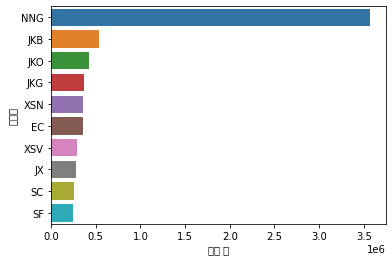

In [24]:
sentence_o = train_df['original_text'].to_list()

tags_o = []
for t in sentence_o:
  temp = m.pos(t)
  for p in temp:
    tags_o.append(p[1])
    
counter=collections.Counter(tags_o)
x,y=list(map(list,zip(*counter.most_common(10))))
ax = sns.barplot(x=y,y=x)
ax.set(xlabel = '빈도 수', ylabel = '형태소')

[Text(0, 0.5, '형태소'), Text(0.5, 0, '빈도 수')]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text

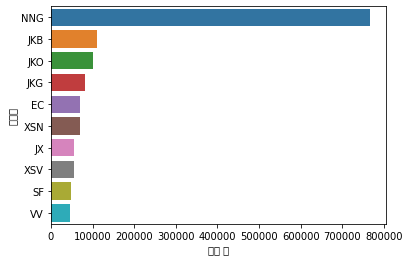

In [25]:
sentence_s = train_df['summary_text'].to_list()

tags_s = []
for t in sentence_s:
  temp = m.pos(t)
  for p in temp:
    tags_s.append(p[1])
    
cnt=collections.Counter(tags_s)
x,y=list(map(list,zip(*cnt.most_common(10))))
ax = sns.barplot(x=y,y=x)
ax.set(xlabel = '빈도 수', ylabel = '형태소')

In [26]:
def get_top_ngram(corpus, n=None):
  vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
  bag_of_words = vec.transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
  words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
  return words_freq

[Text(0, 0.5, '2gram 어절'), Text(0.5, 0, '빈도 수')]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text

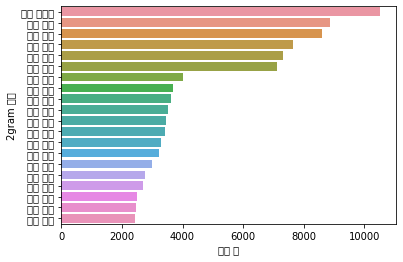

In [27]:
from sklearn.feature_extraction.text import CountVectorizer 
t_corpus_o = [] 
for t in sentence_o: 
  t_corpus_o.append(' '.join(m.morphs(t)))

top_n_bigrams=get_top_ngram(t_corpus_o,2)[:20]
x,y=map(list,zip(*top_n_bigrams))
ax = sns.barplot(x=y,y=x)
ax.set(xlabel = '빈도 수', ylabel = '2gram 어절')

[Text(0, 0.5, '2gram 어절'), Text(0.5, 0, '빈도 수')]

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48712 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text

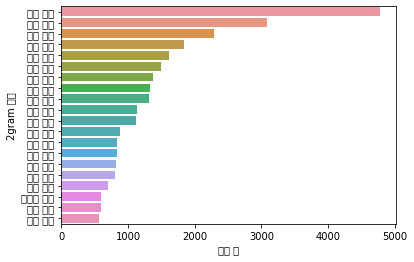

In [28]:
t_corpus_s = [] 
for t in sentence_s: 
  t_corpus_s.append(' '.join(m.morphs(t)))

top_n_bigrams_s=get_top_ngram(t_corpus_s,2)[:20]
x,y=map(list,zip(*top_n_bigrams_s))
ax = sns.barplot(x=y,y=x)
ax.set(xlabel = '빈도 수', ylabel = '2gram 어절')

In [29]:
top_n_bigrams

[('으로 나타났', 10524),
 ('대상 으로', 8880),
 ('연구 에서', 8620),
 ('연구 결과', 7647),
 ('영향 미치', 7314),
 ('분석 결과', 7111),
 ('중심 으로', 4031),
 ('과정 에서', 3670),
 ('바탕 으로', 3613),
 ('연구 목적', 3535),
 ('고자 한다', 3461),
 ('미치 영향', 3409),
 ('우리 나라', 3285),
 ('교육 과정', 3221),
 ('논문 에서', 3001),
 ('측면 에서', 2773),
 ('미치 으로', 2689),
 ('으로 분석', 2497),
 ('관점 에서', 2455),
 ('상호 작용', 2441)]

In [30]:
top_n_bigrams_s

[('연구 에서', 4780),
 ('대상 으로', 3079),
 ('연구 목적', 2287),
 ('미치 영향', 1836),
 ('영향 미치', 1612),
 ('논문 에서', 1501),
 ('중심 으로', 1377),
 ('본고 에서', 1335),
 ('연구 결과', 1309),
 ('우리 나라', 1133),
 ('목적 으로', 1126),
 ('바탕 으로', 887),
 ('교육 과정', 832),
 ('관점 에서', 828),
 ('과정 에서', 821),
 ('고자 한다', 807),
 ('으로 분석', 702),
 ('알아보 고자', 593),
 ('초등 학교', 593),
 ('기초 자료', 571)]

In [31]:
# train_df original_text
t_o = list(train_df['original_text'])
tokenized_t_o = [r.split() for r in t_o]
t_o_len_by_token = [len(t) for t in tokenized_t_o]
t_o_len_by_eumjeol = [len(s.replace(' ', '')) for s in t_o]

In [32]:
# train_df summary_text
t_s = list(train_df['summary_text'])
tokenized_t_s = [r.split() for r in t_s]
t_s_len_by_token = [len(t) for t in tokenized_t_s]
t_s_len_by_eumjeol = [len(s.replace(' ', '')) for s in t_s]

Text(0, 0.5, 'number of original_text')

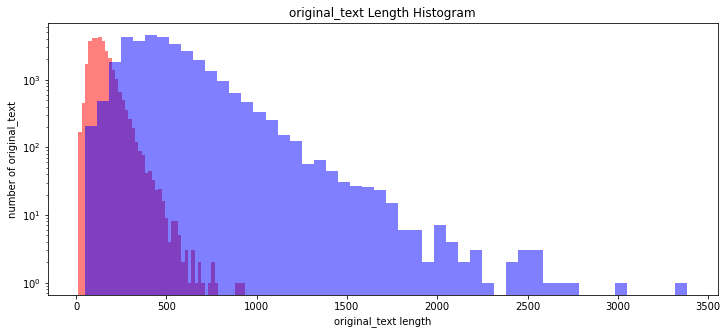

In [33]:
plt.figure(figsize = (12,5))

plt.hist(t_o_len_by_token, bins = 50, alpha=0.5, color="r", label="word")
plt.hist(t_o_len_by_eumjeol, bins = 50, alpha=0.5, color="b", label="aplt.yscallphabet")

plt.yscale('log', nonposy = 'clip')
plt.title('original_text Length Histogram')
plt.xlabel('original_text length')
plt.ylabel('number of original_text')

Text(0, 0.5, 'number of summary_text')

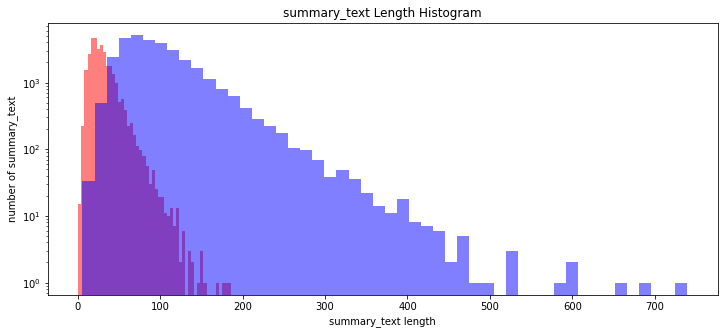

In [34]:
plt.figure(figsize = (12,5))

plt.hist(t_s_len_by_token, bins = 50, alpha=0.5, color="r", label="word")
plt.hist(t_s_len_by_eumjeol, bins = 50, alpha=0.5, color="b", label="aplt.yscallphabet")

plt.yscale('log', nonposy = 'clip')
plt.title('summary_text Length Histogram')
plt.xlabel('summary_text length')
plt.ylabel('number of summary_text')

In [35]:
# 단어갯수기반
print('단어 갯수 기반')
print('문장 최대 길이 : {}'.format(np.max(t_o_len_by_token)))
print('문장 최소 길이 : {}'.format(np.min(t_o_len_by_token)))
print('문장 평균 길이 : {:.2f}'.format(np.mean(t_o_len_by_token)))
print('문장 길이 표준편차 : {:.2f}'.format(np.std(t_o_len_by_token)))
print('문장 중간 길이 : {}'.format(np.median(t_o_len_by_token)))
print('제 1사분위 길이 : {}'.format(np.percentile(t_o_len_by_token, 25)))
print('제 3사분위 길이 : {}'.format(np.percentile(t_o_len_by_token, 75)))
print()

# 알파벳 갯수 기반
print('알파벳 갯수 기반')
print('문장 최대 길이 : {}'.format(np.max(t_o_len_by_eumjeol)))
print('문장 최소 길이 : {}'.format(np.min(t_o_len_by_eumjeol)))
print('문장 평균 길이 : {:.2f}'.format(np.mean(t_o_len_by_eumjeol)))
print('문장 길이 표준편차 : {:.2f}'.format(np.std(t_o_len_by_eumjeol)))
print('문장 중간 길이 : {}'.format(np.median(t_o_len_by_eumjeol)))
print('제 1사분위 길이 : {}'.format(np.percentile(t_o_len_by_eumjeol, 25)))
print('제 3사분위 길이 : {}'.format(np.percentile(t_o_len_by_eumjeol, 75)))

단어 갯수 기반
문장 최대 길이 : 933
문장 최소 길이 : 12
문장 평균 길이 : 139.92
문장 길이 표준편차 : 65.58
문장 중간 길이 : 129.0
제 1사분위 길이 : 94.0
제 3사분위 길이 : 170.0

알파벳 갯수 기반
문장 최대 길이 : 3384
문장 최소 길이 : 48
문장 평균 길이 : 501.14
문장 길이 표준편차 : 232.46
문장 중간 길이 : 462.0
제 1사분위 길이 : 338.0
제 3사분위 길이 : 611.0


In [36]:
# 단어갯수기반
print('단어 갯수 기반')
print('문장 최대 길이 : {}'.format(np.max(t_s_len_by_token)))
print('문장 최소 길이 : {}'.format(np.min(t_s_len_by_token)))
print('문장 평균 길이 : {:.2f}'.format(np.mean(t_s_len_by_token)))
print('문장 길이 표준편차 : {:.2f}'.format(np.std(t_s_len_by_token)))
print('문장 중간 길이 : {}'.format(np.median(t_s_len_by_token)))
print('제 1사분위 길이 : {}'.format(np.percentile(t_s_len_by_token, 25)))
print('제 3사분위 길이 : {}'.format(np.percentile(t_s_len_by_token, 75)))
print()

# 알파벳 갯수 기반
print('알파벳 갯수 기반')
print('문장 최대 길이 : {}'.format(np.max(t_s_len_by_eumjeol)))
print('문장 최소 길이 : {}'.format(np.min(t_s_len_by_eumjeol)))
print('문장 평균 길이 : {:.2f}'.format(np.mean(t_s_len_by_eumjeol)))
print('문장 길이 표준편차 : {:.2f}'.format(np.std(t_s_len_by_eumjeol)))
print('문장 중간 길이 : {}'.format(np.median(t_s_len_by_eumjeol)))
print('제 1사분위 길이 : {}'.format(np.percentile(t_s_len_by_eumjeol, 25)))
print('제 3사분위 길이 : {}'.format(np.percentile(t_s_len_by_eumjeol, 75)))

단어 갯수 기반
문장 최대 길이 : 186
문장 최소 길이 : 1
문장 평균 길이 : 28.80
문장 길이 표준편차 : 14.77
문장 중간 길이 : 26.0
제 1사분위 길이 : 19.0
제 3사분위 길이 : 35.0

알파벳 갯수 기반
문장 최대 길이 : 739
문장 최소 길이 : 6
문장 평균 길이 : 101.16
문장 길이 표준편차 : 51.37
문장 중간 길이 : 90.0
제 1사분위 길이 : 65.0
제 3사분위 길이 : 124.0


In [37]:
# val_df original_text
v_o = list(val_df['original_text'])
tokenized_v_o = [r.split() for r in v_o]
v_o_len_by_token = [len(t) for t in tokenized_v_o]
v_o_len_by_eumjeol = [len(s.replace(' ', '')) for s in v_o]

In [38]:
# val_df summary_text
v_s = list(val_df['summary_text'])
tokenized_v_s = [r.split() for r in v_s]
v_s_len_by_token = [len(t) for t in tokenized_v_s]
v_s_len_by_eumjeol = [len(s.replace(' ', '')) for s in v_s]

Text(0, 0.5, 'number of original_text')

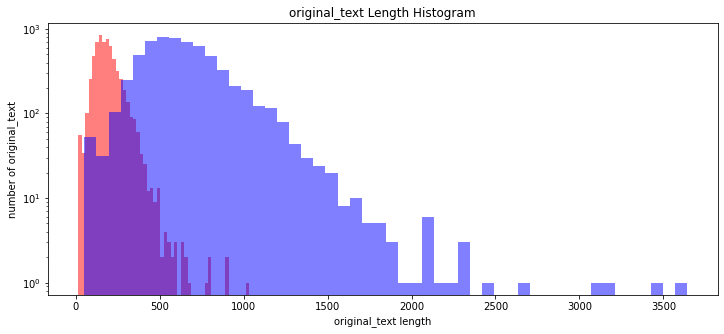

In [39]:
plt.figure(figsize = (12,5))

plt.hist(v_o_len_by_token, bins = 50, alpha=0.5, color="r", label="word")
plt.hist(v_o_len_by_eumjeol, bins = 50, alpha=0.5, color="b", label="aplt.yscallphabet")

plt.yscale('log', nonposy = 'clip')
plt.title('original_text Length Histogram')
plt.xlabel('original_text length')
plt.ylabel('number of original_text')

Text(0, 0.5, 'number of original_text')

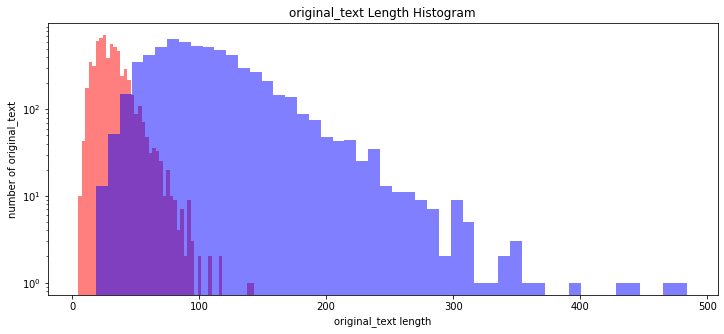

In [40]:
plt.figure(figsize = (12,5))

plt.hist(v_s_len_by_token, bins = 50, alpha=0.5, color="r", label="word")
plt.hist(v_s_len_by_eumjeol, bins = 50, alpha=0.5, color="b", label="aplt.yscallphabet")

plt.yscale('log', nonposy = 'clip')
plt.title('original_text Length Histogram')
plt.xlabel('original_text length')
plt.ylabel('number of original_text')

In [41]:
# 단어갯수기반
print('단어 갯수 기반')
print('문장 최대 길이 : {}'.format(np.max(v_o_len_by_token)))
print('문장 최소 길이 : {}'.format(np.min(v_o_len_by_token)))
print('문장 평균 길이 : {:.2f}'.format(np.mean(v_o_len_by_token)))
print('문장 길이 표준편차 : {:.2f}'.format(np.std(v_o_len_by_token)))
print('문장 중간 길이 : {}'.format(np.median(v_o_len_by_token)))
print('제 1사분위 길이 : {}'.format(np.percentile(v_o_len_by_token, 25)))
print('제 3사분위 길이 : {}'.format(np.percentile(v_o_len_by_token, 75)))
print()

# 알파벳 갯수 기반
print('알파벳 갯수 기반')
print('문장 최대 길이 : {}'.format(np.max(v_o_len_by_eumjeol)))
print('문장 최소 길이 : {}'.format(np.min(v_o_len_by_eumjeol)))
print('문장 평균 길이 : {:.2f}'.format(np.mean(v_o_len_by_eumjeol)))
print('문장 길이 표준편차 : {:.2f}'.format(np.std(v_o_len_by_eumjeol)))
print('문장 중간 길이 : {}'.format(np.median(v_o_len_by_eumjeol)))
print('제 1사분위 길이 : {}'.format(np.percentile(v_o_len_by_eumjeol, 25)))
print('제 3사분위 길이 : {}'.format(np.percentile(v_o_len_by_eumjeol, 75)))

단어 갯수 기반
문장 최대 길이 : 1032
문장 최소 길이 : 16
문장 평균 길이 : 188.95
문장 길이 표준편차 : 79.51
문장 중간 길이 : 178.0
제 1사분위 길이 : 137.0
제 3사분위 길이 : 225.0

알파벳 갯수 기반
문장 최대 길이 : 3641
문장 최소 길이 : 52
문장 평균 길이 : 658.15
문장 길이 표준편차 : 276.60
문장 중간 길이 : 617.0
제 1사분위 길이 : 473.0
제 3사분위 길이 : 785.0


In [42]:
# 단어갯수기반
print('단어 갯수 기반')
print('문장 최대 길이 : {}'.format(np.max(v_s_len_by_token)))
print('문장 최소 길이 : {}'.format(np.min(v_s_len_by_token)))
print('문장 평균 길이 : {:.2f}'.format(np.mean(v_s_len_by_token)))
print('문장 길이 표준편차 : {:.2f}'.format(np.std(v_s_len_by_token)))
print('문장 중간 길이 : {}'.format(np.median(v_s_len_by_token)))
print('제 1사분위 길이 : {}'.format(np.percentile(v_s_len_by_token, 25)))
print('제 3사분위 길이 : {}'.format(np.percentile(v_s_len_by_token, 75)))
print()

# 알파벳 갯수 기반
print('알파벳 갯수 기반')
print('문장 최대 길이 : {}'.format(np.max(v_s_len_by_eumjeol)))
print('문장 최소 길이 : {}'.format(np.min(v_s_len_by_eumjeol)))
print('문장 평균 길이 : {:.2f}'.format(np.mean(v_s_len_by_eumjeol)))
print('문장 길이 표준편차 : {:.2f}'.format(np.std(v_s_len_by_eumjeol)))
print('문장 중간 길이 : {}'.format(np.median(v_s_len_by_eumjeol)))
print('제 1사분위 길이 : {}'.format(np.percentile(v_s_len_by_eumjeol, 25)))
print('제 3사분위 길이 : {}'.format(np.percentile(v_s_len_by_eumjeol, 75)))

단어 갯수 기반
문장 최대 길이 : 143
문장 최소 길이 : 5
문장 평균 길이 : 31.03
문장 길이 표준편차 : 13.23
문장 중간 길이 : 29.0
제 1사분위 길이 : 22.0
제 3사분위 길이 : 38.0

알파벳 갯수 기반
문장 최대 길이 : 484
문장 최소 길이 : 19
문장 평균 길이 : 107.10
문장 길이 표준편차 : 45.82
문장 중간 길이 : 99.0
제 1사분위 길이 : 75.0
제 3사분위 길이 : 129.0


In [43]:
t_o_q = np.mean(train_df['original_text'].apply(lambda x: '?' in x))
t_o_n = np.mean(train_df['original_text'].apply(lambda x: max([y.isdigit() for y in x])))

print('물음표가 있는 문장 : {:.2f}%'.format(t_o_q * 100))
print('숫자가 있는 문장 : {:.2f}%'.format(t_o_n * 100))

물음표가 있는 문장 : 5.12%
숫자가 있는 문장 : 69.27%


가장 긴 문장 길이 : 4168.00
가장 짧은 문장 길이 : 63.00
평균 문장 길이 : 640.06


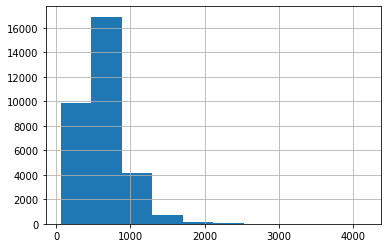

In [87]:
t_o_m = max(train_df['original_text'].str.len())
t_o_mi = min(train_df['original_text'].str.len())
t_o_me = train_df['original_text'].str.len().mean()
print('가장 긴 문장 길이 : {:.2f}'.format(t_o_m))
print('가장 짧은 문장 길이 : {:.2f}'.format(t_o_mi))
print('평균 문장 길이 : {:.2f}'.format(t_o_me))

train_df['original_text'].str.len().hist()

가장 긴 문장 길이 : 870.00
가장 짧은 문장 길이 : 6.00
평균 문장 길이 : 128.96


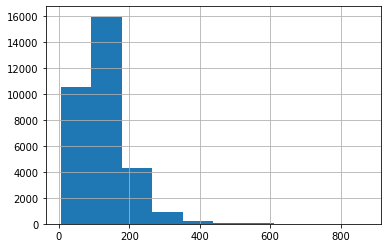

In [81]:
t_s_m = max(train_df['summary_text'].str.len())
t_s_mi = min(train_df['summary_text'].str.len())
t_s_me = train_df['summary_text'].str.len().mean()
print('가장 긴 문장 길이 : {:.2f}'.format(t_s_m))
print('가장 짧은 문장 길이 : {:.2f}'.format(t_s_mi))
print('평균 문장 길이 : {:.2f}'.format(t_s_me))

train_df['summary_text'].str.len().hist()

가장 긴 문장 길이 : 4672.00
가장 짧은 문장 길이 : 68.00
평균 문장 길이 : 846.09


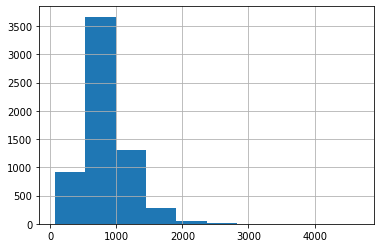

In [89]:
v_o_m = max(val_df['original_text'].str.len())
v_o_mi = min(val_df['original_text'].str.len())
v_o_me = val_df['original_text'].str.len().mean()
print('가장 긴 문장 길이 : {:.2f}'.format(v_o_m))
print('가장 짧은 문장 길이 : {:.2f}'.format(v_o_mi))
print('평균 문장 길이 : {:.2f}'.format(v_o_me))

val_df['original_text'].str.len().hist()

가장 긴 문장 길이 : 626.00
가장 짧은 문장 길이 : 25.00
평균 문장 길이 : 137.13


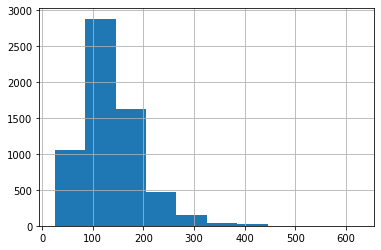

In [90]:
v_s_m = max(val_df['summary_text'].str.len())
v_s_mi = min(val_df['summary_text'].str.len())
v_s_me = val_df['summary_text'].str.len().mean()
print('가장 긴 문장 길이 : {:.2f}'.format(v_s_m))
print('가장 짧은 문장 길이 : {:.2f}'.format(v_s_mi))
print('평균 문장 길이 : {:.2f}'.format(v_s_me))

val_df['summary_text'].str.len().hist()

In [91]:
train_df['ipc'].value_counts()

사회과학    15543
인문학      6437
공학       2900
의약학      2154
예술체육     1479
농수해양     1357
자연과학     1137
복합학       993
Name: ipc, dtype: int64

In [92]:
val_df['ipc'].value_counts()

인문학     5724
사회과학     318
예술체육      59
의약학       50
공학        47
자연과학      44
복합학       11
농수해양       6
Name: ipc, dtype: int64

In [93]:
t_ipc=train_df['ipc'].value_counts(normalize=True)*100
t_ipc

사회과학    48.571875
인문학     20.115625
공학       9.062500
의약학      6.731250
예술체육     4.621875
농수해양     4.240625
자연과학     3.553125
복합학      3.103125
Name: ipc, dtype: float64

In [94]:
v_ipc = val_df['ipc'].value_counts(normalize=True)*100
v_ipc

인문학     91.452309
사회과학     5.080684
예술체육     0.942643
의약학      0.798850
공학       0.750919
자연과학     0.702988
복합학      0.175747
농수해양     0.095862
Name: ipc, dtype: float64